In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA #: functional
using ImageTransformations
using Statistics
using Memento
using NPZ
# using Interpolations
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
# Atype = CuArray{Float32}

KnetArray{Float32, N} where N

In [2]:
const F = Float32
params = Knet.params

params (generic function with 2 methods)

In [3]:
logger = Memento.config!("info"; fmt="[{date} | {level} | {name}]: {msg}");

In [4]:
include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility

In [5]:
dataset_name = "mnist"
notebook_name = "Conv_AutoEncoder_Baseline" * "_" * dataset_name

if !isdir("Results")
   mkdir("Results") 
end
if  !isdir(joinpath("Results", notebook_name))
    mkdir(joinpath("Results", notebook_name))
end

if  !isdir(joinpath("Results", notebook_name, "Saved_Models"))
    mkdir(joinpath("Results", notebook_name, "Saved_Models"))
end

if  !isdir(joinpath("Results", notebook_name, "Images"))
    mkdir(joinpath("Results", notebook_name, "Images"))
end
if  !isdir(joinpath("Results", notebook_name, "Logger"))
    mkdir(joinpath("Results", notebook_name, "Logger"))
end

In [6]:
push!(logger, DefaultHandler(joinpath("Results", notebook_name, "Logger", "logger.log"),DefaultFormatter("[{date} | {level} | {name}]: {msg}")));

In [7]:
use_saved_data = true

if dataset_name == "mnist"
    
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, 1,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, 1,:), xtype = atype);

,,,,,,,,,

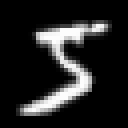
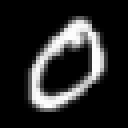
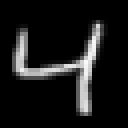
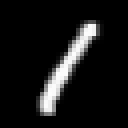
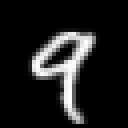
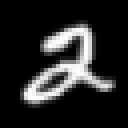
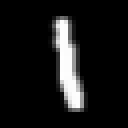
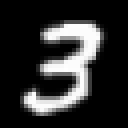
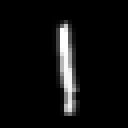
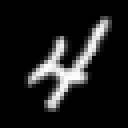

In [8]:
k = 1:10
if use_saved_data
    [Matrix{Gray{Float32}}(reshape(xtrn[:,:,:,j], (32, 32))) for j in k]
else
    [Matrix{Gray{Float32}}(reshape(xtrn[:,:,j], (32, 32))) for j in k]
end

In [9]:
# WEIGHT INITIALIZATON FUNCTION
function weights(nc, nz,  ngf) 
    
    # Encoding Weights
    phi = [] # x -> z
    
    w,b = conv_weight_init(4, 4, nc, ngf; bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    push!(phi, bnparams(ngf))
    
    w,b = conv_weight_init(4, 4, ngf, ngf * 2; bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    push!(phi, bnparams(ngf * 2))
    
    w,b = conv_weight_init(4, 4, ngf * 2, ngf * 4; bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    push!(phi, bnparams(ngf * 4))
    
    w,b = conv_weight_init(4, 4, ngf * 4, nz; bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    
    # Decoding Weights
    theta = [] # z -> x
    
    w, b = deconv_weight_init(4, 4, nz, ngf * 4;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 4))) # Batch Normalization
    
    w, b = deconv_weight_init(4, 4, ngf * 4, ngf * 2;bias= true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 2)))
    
    w, b = deconv_weight_init(4, 4, ngf * 2, ngf;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf)))
    
    w,b = deconv_weight_init(4,4,ngf, nc;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    
    phi = map(a->convert(atype,a), phi)
    theta = map(a->convert(atype,a), theta)
    
    return Param.(theta), Param.(phi)
end

weights (generic function with 1 method)

In [10]:
# Define moments to be used in batchnormalization
moments1 = bnmoments()
moments2 = bnmoments()
moments3 = bnmoments()
moments4 = bnmoments()
moments5 = bnmoments()
moments6 = bnmoments()

# DEFINE ENCODING FUNCTION (MODEL)
function encode(phi, x; batch_size = 64, training = true)
    
    z =  conv4(phi[1], x, mode = 1, stride = 2, padding = 1) .+ phi[2]
    z = mybatchnorm(z, moments1, phi[3]; training = training)
    z = Knet.elu.(z)
    
    z = conv4(phi[4], z, mode = 1, stride = 2, padding = 1) .+ phi[5]
    z = mybatchnorm(z, moments2, phi[6]; training = training)
    z = Knet.elu.(z)
    
    z =  conv4(phi[7], z, mode = 1, stride = 2, padding = 1) .+ phi[8]
    z = mybatchnorm(z, moments3, phi[9]; training = training)
    z = Knet.elu.(z)
    
    z = conv4(phi[10], z, mode = 1) .+ phi[11]
    z = Knet.elu.(z)
    return z
end

# DEFINE DECODING FUNCTION (MODEL)
function decode(theta, z; batch_size = 64, training = true)
    
    z = deconv4(theta[1], z, mode = 1) .+ theta[2]
    z = mybatchnorm(z, moments4, theta[3]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[4], z, mode = 1, stride = 2, padding = 1) .+ theta[5]
    z = mybatchnorm(z, moments5, theta[6]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[7], z, mode = 1, stride = 2, padding = 1) .+ theta[8]
    z = mybatchnorm(z, moments6, theta[9]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[10], z, mode = 1, stride = 2, padding = 1) .+ theta[11]
    x_hat = Knet.sigm.(z)
    return x_hat
    
end

# DEFINE ENCODE_DECODE FUNCTION (NOT REALLY NECESSARY)
function encode_decode(theta, phi, x; batch_size = 64, training = true)

    z = encode(phi, x; batch_size = 64, training = true)
    x_hat = decode(theta, z; batch_size = 64, training = true)
    
    return x_hat
end

encode_decode (generic function with 1 method)

In [11]:
# DEFINE LOSS FUNCTIONS
# inner loss for one batch
function inner_loss(theta, phi, x)
    z = encode(phi, x; batch_size = size(x,4))
    x_hat = decode(theta, z; batch_size = size(x,4))
    #x_hat = encode_decode(theta, phi, x)
    L = mean(sum((x_hat - x).^2,dims = 3))
    return L
end

# inner loss over the whole data
function inner_loss(theta, phi, d::Data)
    total_loss = 0
    n_instance = 0
   for x in d
        total_loss += inner_loss(theta, phi, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end

# Reconstruction Loss Definition (Reconstruction Error := Mean Squared Error)
# reconstruction error over one batch
rec_loss(theta, phi, x) = sum((x - encode_decode(theta, phi, x)).^2) / size(x,4)

# reconstruction error on the whole data
function rec_loss(theta, phi, d::Data)
    total_loss = 0
    n_instance = 0
   for x in d
        total_loss += rec_loss(theta, phi, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end

rec_loss (generic function with 2 methods)

In [12]:
nz = 48
ngf = 32
nc = 1

x_test_first = first(dtst)

theta, phi = weights(nc, nz,  ngf);

derivative_model = @diff inner_loss(theta, phi, x_test_first)

T(0.24880457)

In [13]:
nz = 48
ngf = 32
nc = 1

# first batch of the test dataset
x_test_first = first(dtrn);

# define model weights
theta, phi = weights(nc, nz,  ngf);

# Define Learning Rate and Number of Epochs
lr = 1e-4
n_epochs = 500

# Initialize Empty Lists for both training and test losses
trn_loss_list = Float64[]
tst_loss_list =Float64[]
trn_rec_loss_list = Float64[]
tst_rec_loss_list = Float64[]

# RECORD INITIAL LOSS VALUES
epoch_loss_trn_ = inner_loss(theta, phi, dtrn)
epoch_loss_tst_ = inner_loss(theta, phi, dtst)
epoch_rec_loss_trn_ = rec_loss(theta, phi, dtrn)
epoch_rec_loss_tst_ = rec_loss(theta, phi, dtst)

push!(trn_loss_list, epoch_loss_trn_)
push!(tst_loss_list, epoch_loss_tst_)
push!(trn_rec_loss_list, epoch_rec_loss_trn_)
push!(tst_rec_loss_list, epoch_rec_loss_tst_)

# println("Epoch : ", 0)
# println("Train Loss : ",epoch_loss_trn)
# println("Test Loss : ", epoch_loss_tst)
# println("Train Reconstruction Loss : ", epoch_rec_loss_trn)
# println("Test Reconstruction Loss : ", epoch_rec_loss_tst)


info(logger, ("Epoch : 0"))
info(logger, ("Train Loss : $epoch_loss_trn_"))
info(logger, ("Test Loss : $epoch_loss_tst_"))
info(logger, ("Train Reconstruction Loss : $epoch_rec_loss_trn_"))
info(logger, ("Test Reconstruction Loss : $epoch_rec_loss_tst_ \n"))

# Define the step number of model save checkpoint
model_save_checkpoint = 50
logger_checkpoint = 5
image_rec_checkpoint = 25

# Training Loop
for epoch in progress(1:n_epochs)
    for (i,x) in enumerate(dtrn)
        
        derivative_model = @diff inner_loss(theta, phi, x)
        
        # update the model weights with ADAM optimizer
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999))
        end

        for p in phi
            dp = grad(derivative_model, p)
            update!(value(p), dp, Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999))
        end
    end
    
    # RECORD LOSS VALUES
    epoch_loss_trn = inner_loss(theta, phi, dtrn)
    epoch_loss_tst = inner_loss(theta, phi, dtst)
    epoch_rec_loss_trn = rec_loss(theta, phi, dtrn)
    epoch_rec_loss_tst = rec_loss(theta, phi, dtst)
    
    push!(trn_loss_list, epoch_loss_trn)
    push!(tst_loss_list, epoch_loss_tst)
    push!(trn_rec_loss_list, epoch_rec_loss_trn)
    push!(tst_rec_loss_list, epoch_rec_loss_tst)
    
#     println("Epoch : ", epoch)
#     println("Train Loss : ",epoch_loss_trn)
#     println("Test Loss : ", epoch_loss_tst)
#     println("Train Reconstruction Loss : ", epoch_rec_loss_trn)
#     println("Test Reconstruction Loss : ", epoch_rec_loss_tst)
    
     # Print losses to the logger file
    if epoch % logger_checkpoint == 0
        info(logger,"Epoch : $epoch")
        info(logger,"Train Loss : $epoch_loss_trn")
        info(logger,"Test Loss : $epoch_loss_tst")
        info(logger,"Train Reconstruction Loss : $epoch_rec_loss_trn")
        info(logger,"Test Reconstruction Loss : $epoch_rec_loss_tst \n")
    end
    
    # Plot some reconstruction images
    if ((epoch - 1) % image_rec_checkpoint == 0) || (epoch == n_epochs)
        x_test_first_hat = encode_decode(theta, phi, x_test_first)
        plot_reconstructed_images(x_test_first, x_test_first_hat, 10, batch_size, (900,300))
        fig_name = "Reconstructed_Imgs_ID" * string(1000 + epoch) 
        savefig(joinpath("Results", notebook_name, "Images", fig_name))
    end
    
    # Save model at some steps
    if (epoch % model_save_checkpoint == 0) || (epoch == n_epochs)
        model_id = 1000 + epoch
        model_name = joinpath("Results", notebook_name, "Saved_Models","Model_Base$model_id.jld2")
        w = Dict(:encoder => phi, :decoder => theta)
        Knet.save(model_name,"model",w) 
        ### TO LOAD THE MODEL WEIGHTS, USE THE FOLLOWING
        # w = Knet.load(model_name,"model",) # Ex: model_name = "Results/Conv_AutoEncoder_Baseline_MNIST/Saved_Models/Model_Base1500.jld2"
        # theta = w[:decoder]
        # phi = w[:encoder]
    end
    
end

[2021-12-08 18:28:11 | info | root]: Epoch : 0
[2021-12-08 18:28:11 | info | root]: Train Loss : 0.24915786
[2021-12-08 18:28:11 | info | root]: Test Loss : 0.24955422
[2021-12-08 18:28:11 | info | root]: Train Reconstruction Loss : 255.14102
[2021-12-08 18:28:11 | info | root]: Test Reconstruction Loss : 255.54352 



┣▏                   ┫ [1.00%, 5/500, 01:19/02:11:29, 14.31s/i] 

[2021-12-08 18:29:45 | info | root]: Epoch : 5
[2021-12-08 18:29:45 | info | root]: Train Loss : 0.0029081886
[2021-12-08 18:29:45 | info | root]: Test Loss : 0.0038450747
[2021-12-08 18:29:45 | info | root]: Train Reconstruction Loss : 2.9727397
[2021-12-08 18:29:45 | info | root]: Test Reconstruction Loss : 3.9373565 



┣▍                   ┫ [2.00%, 10/500, 02:30/02:05:00, 14.31s/i] 

[2021-12-08 18:30:56 | info | root]: Epoch : 10
[2021-12-08 18:30:56 | info | root]: Train Loss : 0.002161903
[2021-12-08 18:30:56 | info | root]: Test Loss : 0.003026569
[2021-12-08 18:30:56 | info | root]: Train Reconstruction Loss : 2.2154293
[2021-12-08 18:30:56 | info | root]: Test Reconstruction Loss : 3.0992067 



┣▌                   ┫ [3.00%, 15/500, 03:41/02:03:00, 14.17s/i] 

[2021-12-08 18:32:08 | info | root]: Epoch : 15
[2021-12-08 18:32:08 | info | root]: Train Loss : 0.0020016031
[2021-12-08 18:32:08 | info | root]: Test Loss : 0.0027863933
[2021-12-08 18:32:08 | info | root]: Train Reconstruction Loss : 2.0440373
[2021-12-08 18:32:08 | info | root]: Test Reconstruction Loss : 2.8532667 



┣▊                   ┫ [4.00%, 20/500, 04:53/02:02:11, 14.33s/i] 

[2021-12-08 18:33:20 | info | root]: Epoch : 20
[2021-12-08 18:33:20 | info | root]: Train Loss : 0.0016838055
[2021-12-08 18:33:20 | info | root]: Test Loss : 0.0024718498
[2021-12-08 18:33:20 | info | root]: Train Reconstruction Loss : 1.7258978
[2021-12-08 18:33:20 | info | root]: Test Reconstruction Loss : 2.5311742 



┣█                   ┫ [5.00%, 25/500, 06:05/02:01:45, 14.43s/i] 

[2021-12-08 18:34:32 | info | root]: Epoch : 25
[2021-12-08 18:34:32 | info | root]: Train Loss : 0.0016839295
[2021-12-08 18:34:32 | info | root]: Test Loss : 0.0023869893
[2021-12-08 18:34:32 | info | root]: Train Reconstruction Loss : 1.721206
[2021-12-08 18:34:32 | info | root]: Test Reconstruction Loss : 2.444277 



┣█▏                  ┫ [6.00%, 30/500, 07:18/02:01:35, 14.52s/i] 

[2021-12-08 18:35:44 | info | root]: Epoch : 30
[2021-12-08 18:35:44 | info | root]: Train Loss : 0.001613776
[2021-12-08 18:35:44 | info | root]: Test Loss : 0.0023538761
[2021-12-08 18:35:44 | info | root]: Train Reconstruction Loss : 1.6539079
[2021-12-08 18:35:44 | info | root]: Test Reconstruction Loss : 2.4103692 



┣█▍                  ┫ [7.00%, 35/500, 08:30/02:01:32, 14.50s/i] 

[2021-12-08 18:36:57 | info | root]: Epoch : 35
[2021-12-08 18:36:57 | info | root]: Train Loss : 0.0015831334
[2021-12-08 18:36:57 | info | root]: Test Loss : 0.0023327305
[2021-12-08 18:36:57 | info | root]: Train Reconstruction Loss : 1.621071
[2021-12-08 18:36:57 | info | root]: Test Reconstruction Loss : 2.388716 



┣█▌                  ┫ [8.00%, 40/500, 09:43/02:01:30, 14.68s/i] 

[2021-12-08 18:38:10 | info | root]: Epoch : 40
[2021-12-08 18:38:10 | info | root]: Train Loss : 0.0014623854
[2021-12-08 18:38:10 | info | root]: Test Loss : 0.0020928276
[2021-12-08 18:38:10 | info | root]: Train Reconstruction Loss : 1.4976039
[2021-12-08 18:38:10 | info | root]: Test Reconstruction Loss : 2.1430554 



┣█▊                  ┫ [9.00%, 45/500, 10:56/02:01:32, 14.68s/i] 

[2021-12-08 18:39:23 | info | root]: Epoch : 45
[2021-12-08 18:39:23 | info | root]: Train Loss : 0.0014777279
[2021-12-08 18:39:23 | info | root]: Test Loss : 0.0020830245
[2021-12-08 18:39:23 | info | root]: Train Reconstruction Loss : 1.5159179
[2021-12-08 18:39:23 | info | root]: Test Reconstruction Loss : 2.133017 



┣██                  ┫ [10.00%, 50/500, 12:10/02:01:36, 14.77s/i] 

[2021-12-08 18:40:36 | info | root]: Epoch : 50
[2021-12-08 18:40:36 | info | root]: Train Loss : 0.001422403
[2021-12-08 18:40:36 | info | root]: Test Loss : 0.0020456063
[2021-12-08 18:40:36 | info | root]: Train Reconstruction Loss : 1.4555565
[2021-12-08 18:40:36 | info | root]: Test Reconstruction Loss : 2.0947008 



┣██▏                 ┫ [11.00%, 55/500, 13:31/02:02:53, 14.50s/i] 

[2021-12-08 18:41:58 | info | root]: Epoch : 55
[2021-12-08 18:41:58 | info | root]: Train Loss : 0.0013398791
[2021-12-08 18:41:58 | info | root]: Test Loss : 0.0019172678
[2021-12-08 18:41:58 | info | root]: Train Reconstruction Loss : 1.3687322
[2021-12-08 18:41:58 | info | root]: Test Reconstruction Loss : 1.9632822 



┣██▍                 ┫ [12.00%, 60/500, 14:45/02:02:53, 14.81s/i] 

[2021-12-08 18:43:12 | info | root]: Epoch : 60
[2021-12-08 18:43:12 | info | root]: Train Loss : 0.0013124838
[2021-12-08 18:43:12 | info | root]: Test Loss : 0.001821678
[2021-12-08 18:43:12 | info | root]: Train Reconstruction Loss : 1.3451685
[2021-12-08 18:43:12 | info | root]: Test Reconstruction Loss : 1.8653983 



┣██▌                 ┫ [13.00%, 65/500, 15:59/02:02:54, 14.73s/i] 

[2021-12-08 18:44:25 | info | root]: Epoch : 65
[2021-12-08 18:44:25 | info | root]: Train Loss : 0.0012578539
[2021-12-08 18:44:25 | info | root]: Test Loss : 0.0017784375
[2021-12-08 18:44:25 | info | root]: Train Reconstruction Loss : 1.2879957
[2021-12-08 18:44:25 | info | root]: Test Reconstruction Loss : 1.82112 



┣██▊                 ┫ [14.00%, 70/500, 17:13/02:02:56, 14.93s/i] 

[2021-12-08 18:45:40 | info | root]: Epoch : 70
[2021-12-08 18:45:40 | info | root]: Train Loss : 0.0012182748
[2021-12-08 18:45:40 | info | root]: Test Loss : 0.0017089385
[2021-12-08 18:45:40 | info | root]: Train Reconstruction Loss : 1.2452946
[2021-12-08 18:45:40 | info | root]: Test Reconstruction Loss : 1.749953 



┣███                 ┫ [15.00%, 75/500, 18:27/02:02:59, 14.86s/i] 

[2021-12-08 18:46:54 | info | root]: Epoch : 75
[2021-12-08 18:46:54 | info | root]: Train Loss : 0.0012429683
[2021-12-08 18:46:54 | info | root]: Test Loss : 0.001685065
[2021-12-08 18:46:54 | info | root]: Train Reconstruction Loss : 1.2724985
[2021-12-08 18:46:54 | info | root]: Test Reconstruction Loss : 1.7255065 



┣███▏                ┫ [16.00%, 80/500, 19:42/02:03:09, 14.83s/i] 

[2021-12-08 18:48:09 | info | root]: Epoch : 80
[2021-12-08 18:48:09 | info | root]: Train Loss : 0.001249443
[2021-12-08 18:48:09 | info | root]: Test Loss : 0.0016702431
[2021-12-08 18:48:09 | info | root]: Train Reconstruction Loss : 1.2815624
[2021-12-08 18:48:09 | info | root]: Test Reconstruction Loss : 1.7103289 



┣███▍                ┫ [17.00%, 85/500, 20:57/02:03:12, 14.99s/i] 

[2021-12-08 18:49:24 | info | root]: Epoch : 85
[2021-12-08 18:49:24 | info | root]: Train Loss : 0.0011901992
[2021-12-08 18:49:24 | info | root]: Test Loss : 0.001625346
[2021-12-08 18:49:24 | info | root]: Train Reconstruction Loss : 1.218835
[2021-12-08 18:49:24 | info | root]: Test Reconstruction Loss : 1.6643546 



┣███▌                ┫ [18.00%, 90/500, 22:11/02:03:17, 14.98s/i] 

[2021-12-08 18:50:39 | info | root]: Epoch : 90
[2021-12-08 18:50:39 | info | root]: Train Loss : 0.001173964
[2021-12-08 18:50:39 | info | root]: Test Loss : 0.0015790942
[2021-12-08 18:50:39 | info | root]: Train Reconstruction Loss : 1.2009723
[2021-12-08 18:50:39 | info | root]: Test Reconstruction Loss : 1.6169925 



┣███▊                ┫ [19.00%, 95/500, 23:27/02:03:27, 15.01s/i] 

[2021-12-08 18:51:54 | info | root]: Epoch : 95
[2021-12-08 18:51:54 | info | root]: Train Loss : 0.0011903514
[2021-12-08 18:51:54 | info | root]: Test Loss : 0.0015768226
[2021-12-08 18:51:54 | info | root]: Train Reconstruction Loss : 1.2216482
[2021-12-08 18:51:54 | info | root]: Test Reconstruction Loss : 1.6146662 



┣████                ┫ [20.00%, 100/500, 24:42/02:03:31, 14.88s/i] 

[2021-12-08 18:53:09 | info | root]: Epoch : 100
[2021-12-08 18:53:09 | info | root]: Train Loss : 0.0011370697
[2021-12-08 18:53:09 | info | root]: Test Loss : 0.0014972644
[2021-12-08 18:53:09 | info | root]: Train Reconstruction Loss : 1.1623553
[2021-12-08 18:53:09 | info | root]: Test Reconstruction Loss : 1.5331987 



┣████▏               ┫ [21.00%, 105/500, 26:00/02:03:50, 15.11s/i] 

[2021-12-08 18:54:27 | info | root]: Epoch : 105
[2021-12-08 18:54:27 | info | root]: Train Loss : 0.0011113374
[2021-12-08 18:54:27 | info | root]: Test Loss : 0.0014759373
[2021-12-08 18:54:27 | info | root]: Train Reconstruction Loss : 1.1370963
[2021-12-08 18:54:27 | info | root]: Test Reconstruction Loss : 1.5113598 



┣████▍               ┫ [22.00%, 110/500, 27:16/02:03:55, 15.14s/i] 

[2021-12-08 18:55:43 | info | root]: Epoch : 110
[2021-12-08 18:55:43 | info | root]: Train Loss : 0.0011245072
[2021-12-08 18:55:43 | info | root]: Test Loss : 0.0014500835
[2021-12-08 18:55:43 | info | root]: Train Reconstruction Loss : 1.1518769
[2021-12-08 18:55:43 | info | root]: Test Reconstruction Loss : 1.4848853 



┣████▌               ┫ [23.00%, 115/500, 28:31/02:04:00, 15.25s/i] 

[2021-12-08 18:56:58 | info | root]: Epoch : 115
[2021-12-08 18:56:58 | info | root]: Train Loss : 0.00107387
[2021-12-08 18:56:58 | info | root]: Test Loss : 0.0014112357
[2021-12-08 18:56:58 | info | root]: Train Reconstruction Loss : 1.0986645
[2021-12-08 18:56:58 | info | root]: Test Reconstruction Loss : 1.4451053 



┣████▊               ┫ [24.00%, 120/500, 29:47/02:04:04, 15.11s/i] 

[2021-12-08 18:58:14 | info | root]: Epoch : 120
[2021-12-08 18:58:14 | info | root]: Train Loss : 0.0010673385
[2021-12-08 18:58:14 | info | root]: Test Loss : 0.0014057789
[2021-12-08 18:58:14 | info | root]: Train Reconstruction Loss : 1.0920978
[2021-12-08 18:58:14 | info | root]: Test Reconstruction Loss : 1.4395176 



┣█████               ┫ [25.00%, 125/500, 31:03/02:04:14, 15.13s/i] 

[2021-12-08 18:59:31 | info | root]: Epoch : 125
[2021-12-08 18:59:31 | info | root]: Train Loss : 0.0010317803
[2021-12-08 18:59:31 | info | root]: Test Loss : 0.0013454219
[2021-12-08 18:59:31 | info | root]: Train Reconstruction Loss : 1.0567942
[2021-12-08 18:59:31 | info | root]: Test Reconstruction Loss : 1.377712 



┣█████▏              ┫ [26.00%, 130/500, 32:19/02:04:20, 15.20s/i] 

[2021-12-08 19:00:47 | info | root]: Epoch : 130
[2021-12-08 19:00:47 | info | root]: Train Loss : 0.0010774194
[2021-12-08 19:00:47 | info | root]: Test Loss : 0.0013661494
[2021-12-08 19:00:47 | info | root]: Train Reconstruction Loss : 1.1053032
[2021-12-08 19:00:47 | info | root]: Test Reconstruction Loss : 1.3989369 



┣█████▍              ┫ [27.00%, 135/500, 33:36/02:04:25, 15.25s/i] 

[2021-12-08 19:02:03 | info | root]: Epoch : 135
[2021-12-08 19:02:03 | info | root]: Train Loss : 0.0010348484
[2021-12-08 19:02:03 | info | root]: Test Loss : 0.0013232161
[2021-12-08 19:02:03 | info | root]: Train Reconstruction Loss : 1.0609872
[2021-12-08 19:02:03 | info | root]: Test Reconstruction Loss : 1.3549733 



┣█████▌              ┫ [28.00%, 140/500, 34:52/02:04:31, 15.30s/i] 

[2021-12-08 19:03:19 | info | root]: Epoch : 140
[2021-12-08 19:03:19 | info | root]: Train Loss : 0.0010142497
[2021-12-08 19:03:19 | info | root]: Test Loss : 0.0013096611
[2021-12-08 19:03:19 | info | root]: Train Reconstruction Loss : 1.0396081
[2021-12-08 19:03:19 | info | root]: Test Reconstruction Loss : 1.341093 



┣█████▊              ┫ [29.00%, 145/500, 36:08/02:04:35, 15.16s/i] 

[2021-12-08 19:04:35 | info | root]: Epoch : 145
[2021-12-08 19:04:35 | info | root]: Train Loss : 0.0010184267
[2021-12-08 19:04:35 | info | root]: Test Loss : 0.0013092535
[2021-12-08 19:04:35 | info | root]: Train Reconstruction Loss : 1.0430725
[2021-12-08 19:04:35 | info | root]: Test Reconstruction Loss : 1.3406755 



┣██████              ┫ [30.00%, 150/500, 37:24/02:04:40, 15.11s/i] 

[2021-12-08 19:05:51 | info | root]: Epoch : 150
[2021-12-08 19:05:51 | info | root]: Train Loss : 0.0010207373
[2021-12-08 19:05:51 | info | root]: Test Loss : 0.0013124369
[2021-12-08 19:05:51 | info | root]: Train Reconstruction Loss : 1.0468723
[2021-12-08 19:05:51 | info | root]: Test Reconstruction Loss : 1.3439354 



┣██████▏             ┫ [31.00%, 155/500, 38:43/02:04:53, 15.17s/i] 

[2021-12-08 19:07:10 | info | root]: Epoch : 155
[2021-12-08 19:07:10 | info | root]: Train Loss : 0.0010167602
[2021-12-08 19:07:10 | info | root]: Test Loss : 0.0013140584
[2021-12-08 19:07:10 | info | root]: Train Reconstruction Loss : 1.0416092
[2021-12-08 19:07:10 | info | root]: Test Reconstruction Loss : 1.3455958 



┣██████▍             ┫ [32.00%, 160/500, 39:59/02:04:58, 15.22s/i] 

[2021-12-08 19:08:26 | info | root]: Epoch : 160
[2021-12-08 19:08:26 | info | root]: Train Loss : 0.0009787045
[2021-12-08 19:08:26 | info | root]: Test Loss : 0.0012537137
[2021-12-08 19:08:26 | info | root]: Train Reconstruction Loss : 1.0015246
[2021-12-08 19:08:26 | info | root]: Test Reconstruction Loss : 1.2838029 



┣██████▌             ┫ [33.00%, 165/500, 41:16/02:05:02, 15.42s/i] 

[2021-12-08 19:09:43 | info | root]: Epoch : 165
[2021-12-08 19:09:43 | info | root]: Train Loss : 0.0010036294
[2021-12-08 19:09:43 | info | root]: Test Loss : 0.0012824454
[2021-12-08 19:09:43 | info | root]: Train Reconstruction Loss : 1.027095
[2021-12-08 19:09:43 | info | root]: Test Reconstruction Loss : 1.3132242 



┣██████▊             ┫ [34.00%, 170/500, 42:32/02:05:06, 15.47s/i] 

[2021-12-08 19:11:00 | info | root]: Epoch : 170
[2021-12-08 19:11:00 | info | root]: Train Loss : 0.00097073516
[2021-12-08 19:11:00 | info | root]: Test Loss : 0.001237057
[2021-12-08 19:11:00 | info | root]: Train Reconstruction Loss : 0.9945534
[2021-12-08 19:11:00 | info | root]: Test Reconstruction Loss : 1.2667465 



┣███████             ┫ [35.00%, 175/500, 43:49/02:05:11, 15.41s/i] 

[2021-12-08 19:12:16 | info | root]: Epoch : 175
[2021-12-08 19:12:16 | info | root]: Train Loss : 0.0009963214
[2021-12-08 19:12:16 | info | root]: Test Loss : 0.0012728125
[2021-12-08 19:12:16 | info | root]: Train Reconstruction Loss : 1.0193157
[2021-12-08 19:12:16 | info | root]: Test Reconstruction Loss : 1.30336 



┣███████▏            ┫ [36.00%, 180/500, 45:07/02:05:19, 15.19s/i] 

[2021-12-08 19:13:34 | info | root]: Epoch : 180
[2021-12-08 19:13:34 | info | root]: Train Loss : 0.0009601505
[2021-12-08 19:13:34 | info | root]: Test Loss : 0.0012219506
[2021-12-08 19:13:34 | info | root]: Train Reconstruction Loss : 0.9823491
[2021-12-08 19:13:34 | info | root]: Test Reconstruction Loss : 1.2512774 



┣███████▍            ┫ [37.00%, 185/500, 46:24/02:05:24, 15.37s/i] 

[2021-12-08 19:14:52 | info | root]: Epoch : 185
[2021-12-08 19:14:52 | info | root]: Train Loss : 0.0009892477
[2021-12-08 19:14:52 | info | root]: Test Loss : 0.001248156
[2021-12-08 19:14:52 | info | root]: Train Reconstruction Loss : 1.01274
[2021-12-08 19:14:52 | info | root]: Test Reconstruction Loss : 1.2781117 



┣███████▌            ┫ [38.00%, 190/500, 47:41/02:05:29, 15.38s/i] 

[2021-12-08 19:16:09 | info | root]: Epoch : 190
[2021-12-08 19:16:09 | info | root]: Train Loss : 0.00096583384
[2021-12-08 19:16:09 | info | root]: Test Loss : 0.0012226807
[2021-12-08 19:16:09 | info | root]: Train Reconstruction Loss : 0.99065816
[2021-12-08 19:16:09 | info | root]: Test Reconstruction Loss : 1.2520251 



┣███████▊            ┫ [39.00%, 195/500, 48:58/02:05:35, 15.52s/i] 

[2021-12-08 19:17:26 | info | root]: Epoch : 195
[2021-12-08 19:17:26 | info | root]: Train Loss : 0.00095270056
[2021-12-08 19:17:26 | info | root]: Test Loss : 0.0012101475
[2021-12-08 19:17:26 | info | root]: Train Reconstruction Loss : 0.9749498
[2021-12-08 19:17:26 | info | root]: Test Reconstruction Loss : 1.239191 



┣████████            ┫ [40.00%, 200/500, 50:16/02:05:40, 15.71s/i] 

[2021-12-08 19:18:44 | info | root]: Epoch : 200
[2021-12-08 19:18:44 | info | root]: Train Loss : 0.0009595012
[2021-12-08 19:18:44 | info | root]: Test Loss : 0.0012071576
[2021-12-08 19:18:44 | info | root]: Train Reconstruction Loss : 0.98195034
[2021-12-08 19:18:44 | info | root]: Test Reconstruction Loss : 1.2361294 



┣████████▏           ┫ [41.00%, 205/500, 51:44/02:06:11, 15.56s/i] 

[2021-12-08 19:20:12 | info | root]: Epoch : 205
[2021-12-08 19:20:12 | info | root]: Train Loss : 0.00093522493
[2021-12-08 19:20:12 | info | root]: Test Loss : 0.0011921426
[2021-12-08 19:20:12 | info | root]: Train Reconstruction Loss : 0.95886844
[2021-12-08 19:20:12 | info | root]: Test Reconstruction Loss : 1.220754 



┣████████▍           ┫ [42.00%, 210/500, 53:02/02:06:16, 15.58s/i] 

[2021-12-08 19:21:29 | info | root]: Epoch : 210
[2021-12-08 19:21:29 | info | root]: Train Loss : 0.0009361076
[2021-12-08 19:21:29 | info | root]: Test Loss : 0.0011774393
[2021-12-08 19:21:29 | info | root]: Train Reconstruction Loss : 0.95854634
[2021-12-08 19:21:29 | info | root]: Test Reconstruction Loss : 1.205698 



┣████████▌           ┫ [43.00%, 215/500, 54:20/02:06:21, 15.62s/i] 

[2021-12-08 19:22:48 | info | root]: Epoch : 215
[2021-12-08 19:22:48 | info | root]: Train Loss : 0.0009343581
[2021-12-08 19:22:48 | info | root]: Test Loss : 0.0011804753
[2021-12-08 19:22:48 | info | root]: Train Reconstruction Loss : 0.9566947
[2021-12-08 19:22:48 | info | root]: Test Reconstruction Loss : 1.2088068 



┣████████▊           ┫ [44.00%, 220/500, 55:38/02:06:25, 15.54s/i] 

[2021-12-08 19:24:05 | info | root]: Epoch : 220
[2021-12-08 19:24:05 | info | root]: Train Loss : 0.00092584075
[2021-12-08 19:24:05 | info | root]: Test Loss : 0.0011792876
[2021-12-08 19:24:05 | info | root]: Train Reconstruction Loss : 0.948408
[2021-12-08 19:24:05 | info | root]: Test Reconstruction Loss : 1.2075905 



┣█████████           ┫ [45.00%, 225/500, 56:55/02:06:29, 15.39s/i] 

[2021-12-08 19:25:23 | info | root]: Epoch : 225
[2021-12-08 19:25:23 | info | root]: Train Loss : 0.0009283347
[2021-12-08 19:25:23 | info | root]: Test Loss : 0.0011575319
[2021-12-08 19:25:23 | info | root]: Train Reconstruction Loss : 0.9510552
[2021-12-08 19:25:23 | info | root]: Test Reconstruction Loss : 1.1853126 



┣█████████▏          ┫ [46.00%, 230/500, 58:13/02:06:34, 15.66s/i] 

[2021-12-08 19:26:41 | info | root]: Epoch : 230
[2021-12-08 19:26:41 | info | root]: Train Loss : 0.00091455056
[2021-12-08 19:26:41 | info | root]: Test Loss : 0.0011531644
[2021-12-08 19:26:41 | info | root]: Train Reconstruction Loss : 0.9372049
[2021-12-08 19:26:41 | info | root]: Test Reconstruction Loss : 1.1808404 



┣█████████▍          ┫ [47.00%, 235/500, 59:31/02:06:38, 15.66s/i] 

[2021-12-08 19:27:59 | info | root]: Epoch : 235
[2021-12-08 19:27:59 | info | root]: Train Loss : 0.0009100823
[2021-12-08 19:27:59 | info | root]: Test Loss : 0.001140756
[2021-12-08 19:27:59 | info | root]: Train Reconstruction Loss : 0.9326207
[2021-12-08 19:27:59 | info | root]: Test Reconstruction Loss : 1.1681341 



┣█████████▌          ┫ [48.00%, 240/500, 01:00:49/02:06:43, 15.85s/i] 

[2021-12-08 19:29:17 | info | root]: Epoch : 240
[2021-12-08 19:29:17 | info | root]: Train Loss : 0.00090662297
[2021-12-08 19:29:17 | info | root]: Test Loss : 0.0011340604
[2021-12-08 19:29:17 | info | root]: Train Reconstruction Loss : 0.9284374
[2021-12-08 19:29:17 | info | root]: Test Reconstruction Loss : 1.1612779 



┣█████████▊          ┫ [49.00%, 245/500, 01:02:08/02:06:48, 15.74s/i] 

[2021-12-08 19:30:35 | info | root]: Epoch : 245
[2021-12-08 19:30:35 | info | root]: Train Loss : 0.00090703036
[2021-12-08 19:30:35 | info | root]: Test Loss : 0.0011367841
[2021-12-08 19:30:35 | info | root]: Train Reconstruction Loss : 0.9294556
[2021-12-08 19:30:35 | info | root]: Test Reconstruction Loss : 1.1640667 



┣██████████          ┫ [50.00%, 250/500, 01:03:26/02:06:52, 15.64s/i] 

[2021-12-08 19:31:54 | info | root]: Epoch : 250
[2021-12-08 19:31:54 | info | root]: Train Loss : 0.00089501165
[2021-12-08 19:31:54 | info | root]: Test Loss : 0.0011199786
[2021-12-08 19:31:54 | info | root]: Train Reconstruction Loss : 0.9161167
[2021-12-08 19:31:54 | info | root]: Test Reconstruction Loss : 1.1468583 



┣██████████▏         ┫ [51.00%, 255/500, 01:04:49/02:07:06, 15.92s/i] 

[2021-12-08 19:33:17 | info | root]: Epoch : 255
[2021-12-08 19:33:17 | info | root]: Train Loss : 0.0008816152
[2021-12-08 19:33:17 | info | root]: Test Loss : 0.0011091363
[2021-12-08 19:33:17 | info | root]: Train Reconstruction Loss : 0.9028649
[2021-12-08 19:33:17 | info | root]: Test Reconstruction Loss : 1.1357555 



┣██████████▍         ┫ [52.00%, 260/500, 01:06:08/02:07:11, 15.45s/i] 

[2021-12-08 19:34:36 | info | root]: Epoch : 260
[2021-12-08 19:34:36 | info | root]: Train Loss : 0.00090726285
[2021-12-08 19:34:36 | info | root]: Test Loss : 0.0011388204
[2021-12-08 19:34:36 | info | root]: Train Reconstruction Loss : 0.9294801
[2021-12-08 19:34:36 | info | root]: Test Reconstruction Loss : 1.166152 



┣██████████▌         ┫ [53.00%, 265/500, 01:07:26/02:07:15, 15.39s/i] 

[2021-12-08 19:35:54 | info | root]: Epoch : 265
[2021-12-08 19:35:54 | info | root]: Train Loss : 0.0008840816
[2021-12-08 19:35:54 | info | root]: Test Loss : 0.0011195132
[2021-12-08 19:35:54 | info | root]: Train Reconstruction Loss : 0.90564954
[2021-12-08 19:35:54 | info | root]: Test Reconstruction Loss : 1.1463815 



┣██████████▊         ┫ [54.00%, 270/500, 01:08:45/02:07:19, 15.60s/i] 

[2021-12-08 19:37:13 | info | root]: Epoch : 270
[2021-12-08 19:37:13 | info | root]: Train Loss : 0.0008704071
[2021-12-08 19:37:13 | info | root]: Test Loss : 0.0010972345
[2021-12-08 19:37:13 | info | root]: Train Reconstruction Loss : 0.89179176
[2021-12-08 19:37:13 | info | root]: Test Reconstruction Loss : 1.1235682 



┣███████████         ┫ [55.00%, 275/500, 01:10:04/02:07:23, 15.94s/i] 

[2021-12-08 19:38:33 | info | root]: Epoch : 275
[2021-12-08 19:38:33 | info | root]: Train Loss : 0.0008758313
[2021-12-08 19:38:33 | info | root]: Test Loss : 0.0010985612
[2021-12-08 19:38:33 | info | root]: Train Reconstruction Loss : 0.8965228
[2021-12-08 19:38:33 | info | root]: Test Reconstruction Loss : 1.1249268 



┣███████████▏        ┫ [56.00%, 280/500, 01:11:25/02:07:31, 15.92s/i] 

[2021-12-08 19:39:52 | info | root]: Epoch : 280
[2021-12-08 19:39:52 | info | root]: Train Loss : 0.00087640673
[2021-12-08 19:39:52 | info | root]: Test Loss : 0.0011020078
[2021-12-08 19:39:52 | info | root]: Train Reconstruction Loss : 0.89730614
[2021-12-08 19:39:52 | info | root]: Test Reconstruction Loss : 1.128456 



┣███████████▍        ┫ [57.00%, 285/500, 01:12:44/02:07:36, 16.17s/i] 

[2021-12-08 19:41:12 | info | root]: Epoch : 285
[2021-12-08 19:41:12 | info | root]: Train Loss : 0.0008727212
[2021-12-08 19:41:12 | info | root]: Test Loss : 0.0010888543
[2021-12-08 19:41:12 | info | root]: Train Reconstruction Loss : 0.89405215
[2021-12-08 19:41:12 | info | root]: Test Reconstruction Loss : 1.1149868 



┣███████████▌        ┫ [58.00%, 290/500, 01:14:04/02:07:43, 16.47s/i] 

[2021-12-08 19:42:33 | info | root]: Epoch : 290
[2021-12-08 19:42:33 | info | root]: Train Loss : 0.00087904
[2021-12-08 19:42:33 | info | root]: Test Loss : 0.0011095896
[2021-12-08 19:42:33 | info | root]: Train Reconstruction Loss : 0.90046984
[2021-12-08 19:42:33 | info | root]: Test Reconstruction Loss : 1.1362199 



┣███████████▊        ┫ [59.00%, 295/500, 01:15:29/02:07:56, 16.83s/i] 

[2021-12-08 19:43:57 | info | root]: Epoch : 295
[2021-12-08 19:43:57 | info | root]: Train Loss : 0.0008569109
[2021-12-08 19:43:57 | info | root]: Test Loss : 0.0010742366
[2021-12-08 19:43:57 | info | root]: Train Reconstruction Loss : 0.87796175
[2021-12-08 19:43:57 | info | root]: Test Reconstruction Loss : 1.1000181 



┣████████████        ┫ [60.00%, 300/500, 01:16:55/02:08:11, 18.16s/i] 

[2021-12-08 19:45:24 | info | root]: Epoch : 300
[2021-12-08 19:45:24 | info | root]: Train Loss : 0.00084749836
[2021-12-08 19:45:24 | info | root]: Test Loss : 0.0010575982
[2021-12-08 19:45:24 | info | root]: Train Reconstruction Loss : 0.8677332
[2021-12-08 19:45:24 | info | root]: Test Reconstruction Loss : 1.0829805 



┣████████████▏       ┫ [61.00%, 305/500, 01:18:21/02:08:27, 14.48s/i] 

[2021-12-08 19:46:48 | info | root]: Epoch : 305
[2021-12-08 19:46:48 | info | root]: Train Loss : 0.0008527896
[2021-12-08 19:46:48 | info | root]: Test Loss : 0.001075599
[2021-12-08 19:46:48 | info | root]: Train Reconstruction Loss : 0.87363005
[2021-12-08 19:46:48 | info | root]: Test Reconstruction Loss : 1.1014134 



┣████████████▍       ┫ [62.00%, 310/500, 01:19:34/02:08:20, 14.52s/i] 

[2021-12-08 19:48:00 | info | root]: Epoch : 310
[2021-12-08 19:48:00 | info | root]: Train Loss : 0.0008442328
[2021-12-08 19:48:00 | info | root]: Test Loss : 0.0010530745
[2021-12-08 19:48:00 | info | root]: Train Reconstruction Loss : 0.86493015
[2021-12-08 19:48:00 | info | root]: Test Reconstruction Loss : 1.0783483 



┣████████████▌       ┫ [63.00%, 315/500, 01:20:46/02:08:12, 14.44s/i] 

[2021-12-08 19:49:13 | info | root]: Epoch : 315
[2021-12-08 19:49:13 | info | root]: Train Loss : 0.00084550516
[2021-12-08 19:49:13 | info | root]: Test Loss : 0.0010550136
[2021-12-08 19:49:13 | info | root]: Train Reconstruction Loss : 0.86611056
[2021-12-08 19:49:13 | info | root]: Test Reconstruction Loss : 1.080334 



┣████████████▊       ┫ [64.00%, 320/500, 01:22:00/02:08:07, 14.53s/i] 

[2021-12-08 19:50:26 | info | root]: Epoch : 320
[2021-12-08 19:50:26 | info | root]: Train Loss : 0.000850209
[2021-12-08 19:50:26 | info | root]: Test Loss : 0.0010613791
[2021-12-08 19:50:26 | info | root]: Train Reconstruction Loss : 0.8705316
[2021-12-08 19:50:26 | info | root]: Test Reconstruction Loss : 1.0868522 



┣█████████████       ┫ [65.00%, 325/500, 01:23:13/02:08:01, 14.71s/i] 

[2021-12-08 19:51:39 | info | root]: Epoch : 325
[2021-12-08 19:51:39 | info | root]: Train Loss : 0.000844347
[2021-12-08 19:51:39 | info | root]: Test Loss : 0.0010512548
[2021-12-08 19:51:39 | info | root]: Train Reconstruction Loss : 0.86469835
[2021-12-08 19:51:39 | info | root]: Test Reconstruction Loss : 1.0764849 



┣█████████████▏      ┫ [66.00%, 330/500, 01:24:26/02:07:55, 14.50s/i] 

[2021-12-08 19:52:52 | info | root]: Epoch : 330
[2021-12-08 19:52:52 | info | root]: Train Loss : 0.00084938685
[2021-12-08 19:52:52 | info | root]: Test Loss : 0.0010527726
[2021-12-08 19:52:52 | info | root]: Train Reconstruction Loss : 0.86934245
[2021-12-08 19:52:52 | info | root]: Test Reconstruction Loss : 1.0780392 



┣█████████████▍      ┫ [67.00%, 335/500, 01:25:39/02:07:50, 14.56s/i] 

[2021-12-08 19:54:05 | info | root]: Epoch : 335
[2021-12-08 19:54:05 | info | root]: Train Loss : 0.00083427073
[2021-12-08 19:54:05 | info | root]: Test Loss : 0.0010435128
[2021-12-08 19:54:05 | info | root]: Train Reconstruction Loss : 0.85438555
[2021-12-08 19:54:05 | info | root]: Test Reconstruction Loss : 1.0685573 



┣█████████████▌      ┫ [68.00%, 340/500, 01:26:52/02:07:44, 14.58s/i] 

[2021-12-08 19:55:19 | info | root]: Epoch : 340
[2021-12-08 19:55:19 | info | root]: Train Loss : 0.0008188372
[2021-12-08 19:55:19 | info | root]: Test Loss : 0.001028708
[2021-12-08 19:55:19 | info | root]: Train Reconstruction Loss : 0.83839256
[2021-12-08 19:55:19 | info | root]: Test Reconstruction Loss : 1.0533969 



┣█████████████▊      ┫ [69.00%, 345/500, 01:28:05/02:07:40, 14.74s/i] 

[2021-12-08 19:56:32 | info | root]: Epoch : 345
[2021-12-08 19:56:32 | info | root]: Train Loss : 0.0008268687
[2021-12-08 19:56:32 | info | root]: Test Loss : 0.0010329804
[2021-12-08 19:56:32 | info | root]: Train Reconstruction Loss : 0.8465988
[2021-12-08 19:56:32 | info | root]: Test Reconstruction Loss : 1.057772 



┣██████████████      ┫ [70.00%, 350/500, 01:29:19/02:07:36, 14.67s/i] 

[2021-12-08 19:57:46 | info | root]: Epoch : 350
[2021-12-08 19:57:46 | info | root]: Train Loss : 0.00083452417
[2021-12-08 19:57:46 | info | root]: Test Loss : 0.001041428
[2021-12-08 19:57:46 | info | root]: Train Reconstruction Loss : 0.85527176
[2021-12-08 19:57:46 | info | root]: Test Reconstruction Loss : 1.0664222 



┣██████████████▏     ┫ [71.00%, 355/500, 01:30:37/02:07:38, 14.60s/i] 

[2021-12-08 19:59:04 | info | root]: Epoch : 355
[2021-12-08 19:59:04 | info | root]: Train Loss : 0.00083060766
[2021-12-08 19:59:04 | info | root]: Test Loss : 0.0010357549
[2021-12-08 19:59:04 | info | root]: Train Reconstruction Loss : 0.85046303
[2021-12-08 19:59:04 | info | root]: Test Reconstruction Loss : 1.060613 



┣██████████████▍     ┫ [72.00%, 360/500, 01:31:52/02:07:36, 15.01s/i] 

[2021-12-08 20:00:19 | info | root]: Epoch : 360
[2021-12-08 20:00:19 | info | root]: Train Loss : 0.00081916887
[2021-12-08 20:00:19 | info | root]: Test Loss : 0.0010268423
[2021-12-08 20:00:19 | info | root]: Train Reconstruction Loss : 0.838632
[2021-12-08 20:00:19 | info | root]: Test Reconstruction Loss : 1.0514865 



┣██████████████▌     ┫ [73.00%, 365/500, 01:33:08/02:07:35, 15.16s/i] 

[2021-12-08 20:01:35 | info | root]: Epoch : 365
[2021-12-08 20:01:35 | info | root]: Train Loss : 0.000822718
[2021-12-08 20:01:35 | info | root]: Test Loss : 0.001030167
[2021-12-08 20:01:35 | info | root]: Train Reconstruction Loss : 0.84242976
[2021-12-08 20:01:35 | info | root]: Test Reconstruction Loss : 1.054891 



┣██████████████▊     ┫ [74.00%, 370/500, 01:34:24/02:07:34, 15.32s/i] 

[2021-12-08 20:02:51 | info | root]: Epoch : 370
[2021-12-08 20:02:51 | info | root]: Train Loss : 0.00081445626
[2021-12-08 20:02:51 | info | root]: Test Loss : 0.0010228985
[2021-12-08 20:02:51 | info | root]: Train Reconstruction Loss : 0.83406353
[2021-12-08 20:02:51 | info | root]: Test Reconstruction Loss : 1.047448 



┣███████████████     ┫ [75.00%, 375/500, 01:35:40/02:07:33, 15.07s/i] 

[2021-12-08 20:04:07 | info | root]: Epoch : 375
[2021-12-08 20:04:07 | info | root]: Train Loss : 0.00079961866
[2021-12-08 20:04:07 | info | root]: Test Loss : 0.0010041483
[2021-12-08 20:04:07 | info | root]: Train Reconstruction Loss : 0.8186669
[2021-12-08 20:04:07 | info | root]: Test Reconstruction Loss : 1.0282478 



┣███████████████▏    ┫ [76.00%, 380/500, 01:36:56/02:07:33, 15.61s/i] 

[2021-12-08 20:05:24 | info | root]: Epoch : 380
[2021-12-08 20:05:24 | info | root]: Train Loss : 0.00081433356
[2021-12-08 20:05:24 | info | root]: Test Loss : 0.0010200946
[2021-12-08 20:05:24 | info | root]: Train Reconstruction Loss : 0.83429503
[2021-12-08 20:05:24 | info | root]: Test Reconstruction Loss : 1.0445769 



┣███████████████▍    ┫ [77.00%, 385/500, 01:38:12/02:07:32, 15.11s/i] 

[2021-12-08 20:06:39 | info | root]: Epoch : 385
[2021-12-08 20:06:39 | info | root]: Train Loss : 0.000807991
[2021-12-08 20:06:39 | info | root]: Test Loss : 0.0010171961
[2021-12-08 20:06:39 | info | root]: Train Reconstruction Loss : 0.82642317
[2021-12-08 20:06:39 | info | root]: Test Reconstruction Loss : 1.0416088 



┣███████████████▌    ┫ [78.00%, 390/500, 01:39:29/02:07:33, 16.36s/i] 

[2021-12-08 20:07:56 | info | root]: Epoch : 390
[2021-12-08 20:07:56 | info | root]: Train Loss : 0.00082095107
[2021-12-08 20:07:56 | info | root]: Test Loss : 0.0010217394
[2021-12-08 20:07:56 | info | root]: Train Reconstruction Loss : 0.84018636
[2021-12-08 20:07:56 | info | root]: Test Reconstruction Loss : 1.0462612 



┣███████████████▊    ┫ [79.00%, 395/500, 01:40:47/02:07:34, 15.16s/i] 

[2021-12-08 20:09:14 | info | root]: Epoch : 395
[2021-12-08 20:09:14 | info | root]: Train Loss : 0.00080758386
[2021-12-08 20:09:14 | info | root]: Test Loss : 0.0010147183
[2021-12-08 20:09:14 | info | root]: Train Reconstruction Loss : 0.82753694
[2021-12-08 20:09:14 | info | root]: Test Reconstruction Loss : 1.0390716 



┣████████████████    ┫ [80.00%, 400/500, 01:42:03/02:07:34, 15.25s/i] 

[2021-12-08 20:10:30 | info | root]: Epoch : 400
[2021-12-08 20:10:30 | info | root]: Train Loss : 0.00080593635
[2021-12-08 20:10:30 | info | root]: Test Loss : 0.0010107349
[2021-12-08 20:10:30 | info | root]: Train Reconstruction Loss : 0.8253897
[2021-12-08 20:10:30 | info | root]: Test Reconstruction Loss : 1.0349925 



┣████████████████▏   ┫ [81.00%, 405/500, 01:43:34/02:07:52, 15.26s/i] 

[2021-12-08 20:12:02 | info | root]: Epoch : 405
[2021-12-08 20:12:02 | info | root]: Train Loss : 0.0008086036
[2021-12-08 20:12:02 | info | root]: Test Loss : 0.0010057273
[2021-12-08 20:12:02 | info | root]: Train Reconstruction Loss : 0.8282055
[2021-12-08 20:12:02 | info | root]: Test Reconstruction Loss : 1.0298648 



┣████████████████▍   ┫ [82.00%, 410/500, 01:44:49/02:07:50, 14.68s/i] 

[2021-12-08 20:13:17 | info | root]: Epoch : 410
[2021-12-08 20:13:17 | info | root]: Train Loss : 0.0008060129
[2021-12-08 20:13:17 | info | root]: Test Loss : 0.0010084965
[2021-12-08 20:13:17 | info | root]: Train Reconstruction Loss : 0.8258219
[2021-12-08 20:13:17 | info | root]: Test Reconstruction Loss : 1.0327004 



┣████████████████▌   ┫ [83.00%, 415/500, 01:46:07/02:07:51, 15.77s/i] 

[2021-12-08 20:14:35 | info | root]: Epoch : 415
[2021-12-08 20:14:35 | info | root]: Train Loss : 0.0007954968
[2021-12-08 20:14:35 | info | root]: Test Loss : 0.0010008923
[2021-12-08 20:14:35 | info | root]: Train Reconstruction Loss : 0.81442374
[2021-12-08 20:14:35 | info | root]: Test Reconstruction Loss : 1.0249137 



┣████████████████▊   ┫ [84.00%, 420/500, 01:47:26/02:07:54, 15.37s/i] 

[2021-12-08 20:15:54 | info | root]: Epoch : 420
[2021-12-08 20:15:54 | info | root]: Train Loss : 0.0007895013
[2021-12-08 20:15:54 | info | root]: Test Loss : 0.0010009533
[2021-12-08 20:15:54 | info | root]: Train Reconstruction Loss : 0.8087385
[2021-12-08 20:15:54 | info | root]: Test Reconstruction Loss : 1.0249761 



┣█████████████████   ┫ [85.00%, 425/500, 01:48:46/02:07:57, 15.73s/i] 

[2021-12-08 20:17:14 | info | root]: Epoch : 425
[2021-12-08 20:17:14 | info | root]: Train Loss : 0.00079339446
[2021-12-08 20:17:14 | info | root]: Test Loss : 0.0009947788
[2021-12-08 20:17:14 | info | root]: Train Reconstruction Loss : 0.8126956
[2021-12-08 20:17:14 | info | root]: Test Reconstruction Loss : 1.0186534 



┣█████████████████▏  ┫ [86.00%, 430/500, 01:50:05/02:08:00, 15.91s/i] 

[2021-12-08 20:18:33 | info | root]: Epoch : 430
[2021-12-08 20:18:33 | info | root]: Train Loss : 0.00078890927
[2021-12-08 20:18:33 | info | root]: Test Loss : 0.0009957129
[2021-12-08 20:18:33 | info | root]: Train Reconstruction Loss : 0.8077812
[2021-12-08 20:18:33 | info | root]: Test Reconstruction Loss : 1.01961 



┣█████████████████▍  ┫ [87.00%, 435/500, 01:51:23/02:08:01, 15.53s/i] 

[2021-12-08 20:19:50 | info | root]: Epoch : 435
[2021-12-08 20:19:50 | info | root]: Train Loss : 0.0007880901
[2021-12-08 20:19:50 | info | root]: Test Loss : 0.0009891724
[2021-12-08 20:19:50 | info | root]: Train Reconstruction Loss : 0.8075731
[2021-12-08 20:19:50 | info | root]: Test Reconstruction Loss : 1.0129125 



┣█████████████████▌  ┫ [88.00%, 440/500, 01:52:41/02:08:03, 15.80s/i] 

[2021-12-08 20:21:08 | info | root]: Epoch : 440
[2021-12-08 20:21:08 | info | root]: Train Loss : 0.0007905508
[2021-12-08 20:21:08 | info | root]: Test Loss : 0.0009952957
[2021-12-08 20:21:08 | info | root]: Train Reconstruction Loss : 0.8098006
[2021-12-08 20:21:08 | info | root]: Test Reconstruction Loss : 1.0191828 



┣█████████████████▊  ┫ [89.00%, 445/500, 01:53:59/02:08:04, 15.61s/i] 

[2021-12-08 20:22:27 | info | root]: Epoch : 445
[2021-12-08 20:22:27 | info | root]: Train Loss : 0.0007755732
[2021-12-08 20:22:27 | info | root]: Test Loss : 0.0009825049
[2021-12-08 20:22:27 | info | root]: Train Reconstruction Loss : 0.7946329
[2021-12-08 20:22:27 | info | root]: Test Reconstruction Loss : 1.006085 



┣██████████████████  ┫ [90.00%, 450/500, 01:55:17/02:08:06, 15.64s/i] 

[2021-12-08 20:23:45 | info | root]: Epoch : 450
[2021-12-08 20:23:45 | info | root]: Train Loss : 0.00078116637
[2021-12-08 20:23:45 | info | root]: Test Loss : 0.0009812685
[2021-12-08 20:23:45 | info | root]: Train Reconstruction Loss : 0.8000061
[2021-12-08 20:23:45 | info | root]: Test Reconstruction Loss : 1.0048189 



┣██████████████████▏ ┫ [91.00%, 455/500, 01:56:37/02:08:09, 15.68s/i] 

[2021-12-08 20:25:04 | info | root]: Epoch : 455
[2021-12-08 20:25:04 | info | root]: Train Loss : 0.00076806004
[2021-12-08 20:25:04 | info | root]: Test Loss : 0.00096607435
[2021-12-08 20:25:04 | info | root]: Train Reconstruction Loss : 0.786912
[2021-12-08 20:25:04 | info | root]: Test Reconstruction Loss : 0.98926014 



┣██████████████████▍ ┫ [92.00%, 460/500, 01:57:55/02:08:10, 15.65s/i] 

[2021-12-08 20:26:23 | info | root]: Epoch : 460
[2021-12-08 20:26:23 | info | root]: Train Loss : 0.0007694722
[2021-12-08 20:26:23 | info | root]: Test Loss : 0.00096091983
[2021-12-08 20:26:23 | info | root]: Train Reconstruction Loss : 0.7873741
[2021-12-08 20:26:23 | info | root]: Test Reconstruction Loss : 0.9839819 



┣██████████████████▌ ┫ [93.00%, 465/500, 01:59:13/02:08:12, 15.68s/i] 

[2021-12-08 20:27:41 | info | root]: Epoch : 465
[2021-12-08 20:27:41 | info | root]: Train Loss : 0.00077087036
[2021-12-08 20:27:41 | info | root]: Test Loss : 0.00097067165
[2021-12-08 20:27:41 | info | root]: Train Reconstruction Loss : 0.78955364
[2021-12-08 20:27:41 | info | root]: Test Reconstruction Loss : 0.9939677 



┣██████████████████▊ ┫ [94.00%, 470/500, 02:00:32/02:08:14, 15.71s/i] 

[2021-12-08 20:29:00 | info | root]: Epoch : 470
[2021-12-08 20:29:00 | info | root]: Train Loss : 0.0007747683
[2021-12-08 20:29:00 | info | root]: Test Loss : 0.00097555784
[2021-12-08 20:29:00 | info | root]: Train Reconstruction Loss : 0.7931762
[2021-12-08 20:29:00 | info | root]: Test Reconstruction Loss : 0.9989713 



┣███████████████████ ┫ [95.00%, 475/500, 02:01:51/02:08:16, 15.80s/i] 

[2021-12-08 20:30:19 | info | root]: Epoch : 475
[2021-12-08 20:30:19 | info | root]: Train Loss : 0.00077801547
[2021-12-08 20:30:19 | info | root]: Test Loss : 0.0009780092
[2021-12-08 20:30:19 | info | root]: Train Reconstruction Loss : 0.7966034
[2021-12-08 20:30:19 | info | root]: Test Reconstruction Loss : 1.0014814 



┣███████████████████▏┫ [96.00%, 480/500, 02:03:11/02:08:19, 15.80s/i] 

[2021-12-08 20:31:39 | info | root]: Epoch : 480
[2021-12-08 20:31:39 | info | root]: Train Loss : 0.0007723465
[2021-12-08 20:31:39 | info | root]: Test Loss : 0.00096746936
[2021-12-08 20:31:39 | info | root]: Train Reconstruction Loss : 0.79100347
[2021-12-08 20:31:39 | info | root]: Test Reconstruction Loss : 0.9906886 



┣███████████████████▍┫ [97.00%, 485/500, 02:04:30/02:08:21, 15.86s/i] 

[2021-12-08 20:32:58 | info | root]: Epoch : 485
[2021-12-08 20:32:58 | info | root]: Train Loss : 0.00077311817
[2021-12-08 20:32:58 | info | root]: Test Loss : 0.000970843
[2021-12-08 20:32:58 | info | root]: Train Reconstruction Loss : 0.7912109
[2021-12-08 20:32:58 | info | root]: Test Reconstruction Loss : 0.99414325 



┣███████████████████▌┫ [98.00%, 490/500, 02:05:49/02:08:24, 15.88s/i] 

[2021-12-08 20:34:17 | info | root]: Epoch : 490
[2021-12-08 20:34:17 | info | root]: Train Loss : 0.0007682592
[2021-12-08 20:34:17 | info | root]: Test Loss : 0.0009594743
[2021-12-08 20:34:17 | info | root]: Train Reconstruction Loss : 0.7871173
[2021-12-08 20:34:17 | info | root]: Test Reconstruction Loss : 0.9825017 



┣███████████████████▊┫ [99.00%, 495/500, 02:07:09/02:08:26, 15.81s/i] 

[2021-12-08 20:35:37 | info | root]: Epoch : 495
[2021-12-08 20:35:37 | info | root]: Train Loss : 0.0007649135
[2021-12-08 20:35:37 | info | root]: Test Loss : 0.0009611676
[2021-12-08 20:35:37 | info | root]: Train Reconstruction Loss : 0.7829138
[2021-12-08 20:35:37 | info | root]: Test Reconstruction Loss : 0.98423564 



┣████████████████████┫ [100.00%, 500/500, 02:08:30/02:08:30, 16.91s/i] 

[2021-12-08 20:36:58 | info | root]: Epoch : 500
[2021-12-08 20:36:58 | info | root]: Train Loss : 0.0007536692
[2021-12-08 20:36:58 | info | root]: Test Loss : 0.0009518154
[2021-12-08 20:36:58 | info | root]: Train Reconstruction Loss : 0.77287096
[2021-12-08 20:36:58 | info | root]: Test Reconstruction Loss : 0.97465897 



┣████████████████████┫ [100.00%, 500/500, 02:08:49/02:08:49, 15.46s/i] 


In [14]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end]; title = "Train & Test Loss w.r.t. Epochs")
fig_name = "Train_and_test_loss"
savefig(joinpath("Results", notebook_name, fig_name))

In [15]:
plot_loss_convergence(trn_rec_loss_list[2:end], tst_rec_loss_list[2:end]; title = "Train & Test Reconstruction Loss w.r.t. Epochs")
fig_name = "Train_and_test_reconstruction_loss"
savefig(joinpath("Results", notebook_name, fig_name))

In [16]:
info(logger, "Training is done!")
info(logger, "We will report the last loss values for both training and test sets.\n")

epoch_loss_trn = inner_loss(theta, phi, dtrn)
epoch_loss_tst = inner_loss(theta, phi, dtst)
epoch_rec_loss_trn = rec_loss(theta, phi, dtrn)
epoch_rec_loss_tst = rec_loss(theta, phi, dtst)

info(logger,"Train Loss : $epoch_loss_trn")
info(logger,"Test Loss : $epoch_loss_tst")
info(logger,"Train Reconstruction Loss : $epoch_rec_loss_trn")
info(logger,"Test Reconstruction Loss : $epoch_rec_loss_tst \n")

[2021-12-08 20:37:10 | info | root]: Training is done!
[2021-12-08 20:37:10 | info | root]: We will report the last loss values for both training and test sets.

[2021-12-08 20:37:16 | info | root]: Train Loss : 0.00075427623
[2021-12-08 20:37:16 | info | root]: Test Loss : 0.0009518154
[2021-12-08 20:37:16 | info | root]: Train Reconstruction Loss : 0.772598
[2021-12-08 20:37:16 | info | root]: Test Reconstruction Loss : 0.97465897 



In [17]:
Knet.save(joinpath("Results", notebook_name,"trn_loss_list.jld2"),"trn_loss_list",trn_loss_list) 
Knet.save(joinpath("Results", notebook_name,"tst_loss_list.jld2"),"tst_loss_list",tst_loss_list) 
Knet.save(joinpath("Results", notebook_name,"trn_rec_loss_list.jld2"),"trn_rec_loss_list",trn_rec_loss_list) 
Knet.save(joinpath("Results", notebook_name,"tst_rec_loss_list.jld2"),"tst_rec_loss_list",tst_rec_loss_list) 